<h1><center>Проект Восстановление золота</center></h1>


# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


# Описание данных


Данные находятся в трёх файлах:
- gold_recovery_train.csv — обучающая выборка;
- gold_recovery_test.csv — тестовая выборка;
- gold_recovery_full.csv — исходные данные.


Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.


В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

# 1. Подготовка данных

- Импортируем библиотеки

In [1]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, ParameterGrid
from sklearn.metrics import make_scorer
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyRegressor

- Загрузим датасеты

In [2]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

- Общая информация: Обучающая выборка

In [3]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

- Общая информация: Тестовая выборка

In [4]:
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

- Общая информация: Исходные данные

In [5]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

- Табличная информация

In [6]:
print()
print('-------------- Исходные данные --------------')
print()
display(gold_recovery_full.head())

print()
print('-------------- Обучающая выборка --------------')
print()
display(gold_recovery_train.head())

print()
print('-------------- Тестовая выборка --------------')
print()
display(gold_recovery_test.head())


-------------- Исходные данные --------------



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



-------------- Обучающая выборка --------------



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



-------------- Тестовая выборка --------------



,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


- Проверим, что эффективность обогащения рассчитана правильно

In [7]:
display(gold_recovery_train[['rougher.input.feed_au','rougher.output.concentrate_au', 'rougher.output.tail_au', 'rougher.output.recovery']])

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au,rougher.output.recovery
0,6.486150,19.793808,1.170244,87.107763
1,6.478583,20.050975,1.184827,86.843261
2,6.362222,19.737170,1.162562,86.842308
3,6.118189,19.320810,1.079755,87.226430
4,5.663707,19.216101,1.012642,86.688794
...,...,...,...,...
16855,5.335862,18.603550,0.748633,89.574376
16856,4.838619,18.441436,0.771582,87.724007
16857,4.525061,15.111231,0.685059,88.890579
16858,4.362781,17.834772,0.567130,89.858126


- Напишем функцию для расчета эффективности обогащения

In [8]:
def recovery(row):
    
    f = row[0]
    c = row[1]
    t = row[2]
    
    rec = c*(f-t)/f/(c-t)*100
    
    return rec

In [9]:
warnings.filterwarnings('ignore')

gold_recovery_train['rougher.output.recovery_check'] = gold_recovery_train[['rougher.input.feed_au','rougher.output.concentrate_au', 'rougher.output.tail_au']].apply(recovery, axis=1)
display(gold_recovery_train[['rougher.output.recovery', 'rougher.output.recovery_check']].head(5))

,rougher.output.recovery,rougher.output.recovery_check
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [10]:
print('Количество предоставленных значений эффективности в обучающей выборке: ', gold_recovery_train['rougher.output.recovery'].count())
print()
print('Количество рассчитанных значений эффективности в обучающей выборке: ', gold_recovery_train['rougher.output.recovery_check'].count())

Количество предоставленных значений эффективности в обучающей выборке:  14287

Количество рассчитанных значений эффективности в обучающей выборке:  14577


- Количество рассчитанных значений эффективности в обучающей выборке больше, чем предоставленных, следовательно в исходных данных есть пропущенные значения этого параметра

- Определим MAE (Mean Average Error) между предоставленными значениями эффективности и рассчитанными по формуле    

In [11]:
print('MAE между предоставленными и рассчитанными значениями эффективности =', round(mean_absolute_error(gold_recovery_train['rougher.output.recovery'].dropna(), gold_recovery_train['rougher.output.recovery_check'].loc[gold_recovery_train['rougher.output.recovery'].dropna().index]),6))

MAE между предоставленными и рассчитанными значениями эффективности = 0.0


- MAE между предоставленными и рассчитанными значениями эффективности равно 0 до степени точности данных


- Следовательно, часть пропущенных значений эффектинвости можно рассчитать по формуле

In [12]:
 gold_recovery_train.drop(['rougher.output.recovery_check'], axis=1, inplace=True)

- Удалим нулейвые и пропущенные значения из обучающей выборки

In [13]:
gold_recovery_train.dropna(inplace=True)
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  11017 non-null object
final.output.concentrate_ag                           11017 non-null float64
final.output.concentrate_pb                           11017 non-null float64
final.output.concentrate_sol                          11017 non-null float64
final.output.concentrate_au                           11017 non-null float64
final.output.recovery                                 11017 non-null float64
final.output.tail_ag                                  11017 non-null float64
final.output.tail_pb                                  11017 non-null float64
final.output.tail_sol                                 11017 non-null float64
final.output.tail_au                                  11017 non-null float64
primary_cleaner.input.sulfate                         11017 non-null float64
primary_cleaner.input.depressant             

- Оценим распределения выходных параметров rougher.output.recovery и final.output.recovery

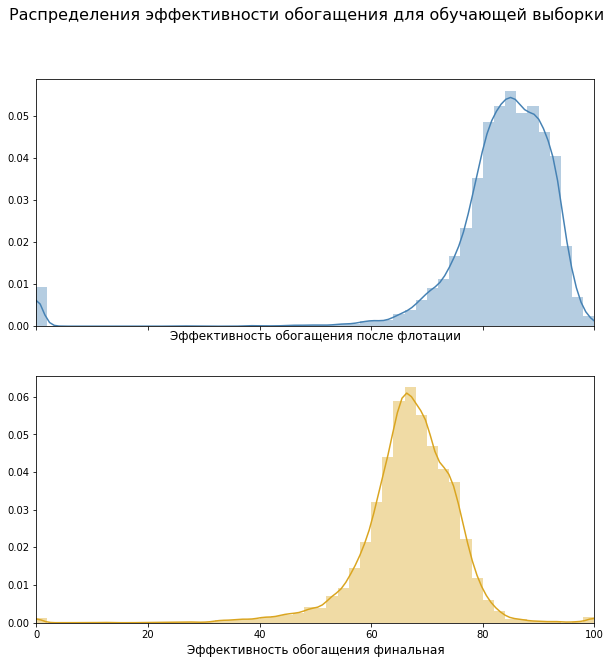

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

sns.distplot(gold_recovery_train['rougher.output.recovery'], ax=ax1, color='steelblue')
sns.distplot(gold_recovery_train['final.output.recovery'], ax=ax2, color='goldenrod')

ax1.set_xlabel('Эффективность обогащения после флотации', fontsize=12)
ax2.set_xlabel('Эффективность обогащения финальная', fontsize=12)

ax1.set_xlim([0, 100])

fig.suptitle('Распределения эффективности обогащения для обучающей выборки', fontsize=16)
plt.show()

- В распределениях эффективности обогащения присутсвуют нулевые значения, которые больше похоже на выбросы и вряд ли соотвествуют реальному процессу, поэтому удалим их

In [15]:
gold_recovery_train = gold_recovery_train[(gold_recovery_train['rougher.output.recovery']>0) & (gold_recovery_train['final.output.recovery']>0)]

- Проанализируем признаки, недоступные в тестовой выборке


- Разделим все признаки на 4 категории:

    1. rougher — флотация
    2. primary_cleaner — первичная очистка
    3. secondary_cleaner — вторичная очистка
    4. final — финальные характеристики
    


In [16]:
rougher_train_cols = [col for col in gold_recovery_train.columns if 'rougher' in col]
rougher_test_cols = [col for col in gold_recovery_test.columns if 'rougher' in col]

rougher_test_missing_col = []

for i in range(len(rougher_train_cols)):
    if (rougher_train_cols[i] in rougher_test_cols)==False:
        rougher_test_missing_col.append(rougher_train_cols[i])
    i=+1

print('Признаки этапа флотация, не представленные в тестовой выборке:')

display(rougher_test_missing_col)

Признаки этапа флотация, не представленные в тестовой выборке:


['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au']

- Для этапа фтолации в тестовой выборке не представлены признаки:

    1. Характеристики системы (calculation)
    2. Выходная концентрации веществ (output.concentrate)
    3. Выходная концентрации веществ в хвостах (output.tail)
    4. Эффективность обогащения (output.recovery)

In [17]:
primary_cleaner_train_cols = [col for col in gold_recovery_train.columns if 'primary_cleaner' in col]
primary_cleaner_test_cols = [col for col in gold_recovery_test.columns if 'primary_cleaner' in col]

primary_cleaner_test_missing_col = []

for i in range(len(primary_cleaner_train_cols)):
    if (primary_cleaner_train_cols[i] in primary_cleaner_test_cols)==False:
        primary_cleaner_test_missing_col.append(primary_cleaner_train_cols[i])
    i=+1

print('Признаки этапа первичной очистки, не представленные в тестовой выборке:')

display(primary_cleaner_test_missing_col)

Признаки этапа первичной очистки, не представленные в тестовой выборке:


['primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au']

- Для этапа первичной очистки в тестовой выборке не представлены признаки:

    1. Выходная концентрации веществ (output.concentrate)
    2. Выходная концентрации веществ в хвостах (output.tail)


In [18]:
secondary_cleaner_train_cols = [col for col in gold_recovery_train.columns if 'secondary_cleaner' in col]
secondary_cleaner_test_cols = [col for col in gold_recovery_test.columns if 'secondary_cleaner' in col]

secondary_cleaner_test_missing_col = []

for i in range(len(secondary_cleaner_train_cols)):
    if (secondary_cleaner_train_cols[i] in secondary_cleaner_test_cols)==False:
        secondary_cleaner_test_missing_col.append(secondary_cleaner_train_cols[i])
    i=+1

print('Признаки этапа вторичной очистки, не представленные в тестовой выборке:')

display(secondary_cleaner_test_missing_col)

Признаки этапа вторичной очистки, не представленные в тестовой выборке:


['secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au']

- Для этапа первичной очистки в тестовой выборке не представлены признаки:

    1. Выходная концентрации веществ (output.concentrate)


In [19]:
final_train_cols = [col for col in gold_recovery_train.columns if 'final' in col]
final_test_cols = [col for col in gold_recovery_test.columns if 'final' in col]

final_test_missing_col = []

for i in range(len(final_train_cols)):
    if (final_train_cols[i] in final_test_cols)==False:
        final_test_missing_col.append(final_train_cols[i])
    i=+1

print('Признаки финальные, не представленные в тестовой выборке:')

display(final_test_missing_col)

Признаки финальные, не представленные в тестовой выборке:


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au']

- Среди финальных характеристик в тестовой выборке не представлены признаки:

    1. Выходная концентрации веществ (output.concentrate)
    2. Выходная концентрации веществ в хвостах (output.tail)
    3. Эффективность обогащения (output.recovery)

- В целом в тестовой выборке отсутствуют выходные параметры различных этапов

In [20]:
missing_columns = rougher_test_missing_col + primary_cleaner_test_missing_col + secondary_cleaner_test_missing_col + final_test_missing_col

# 2. Анализ данных

- Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

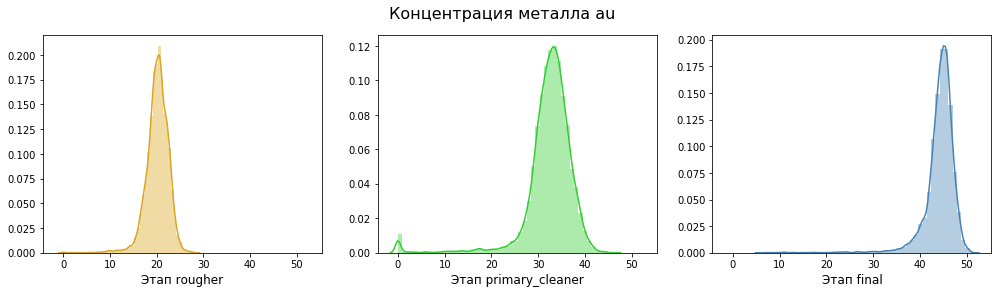

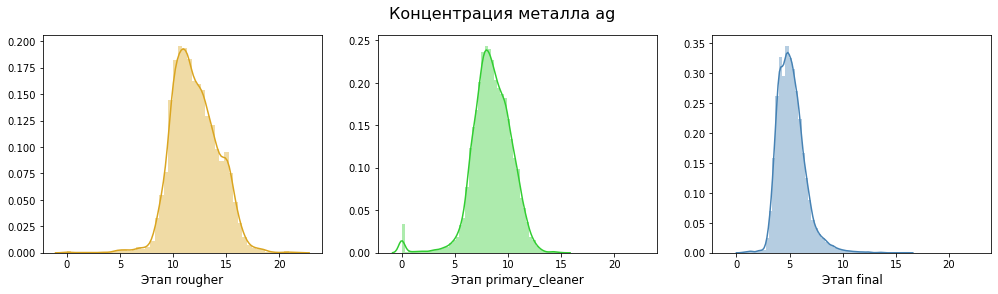

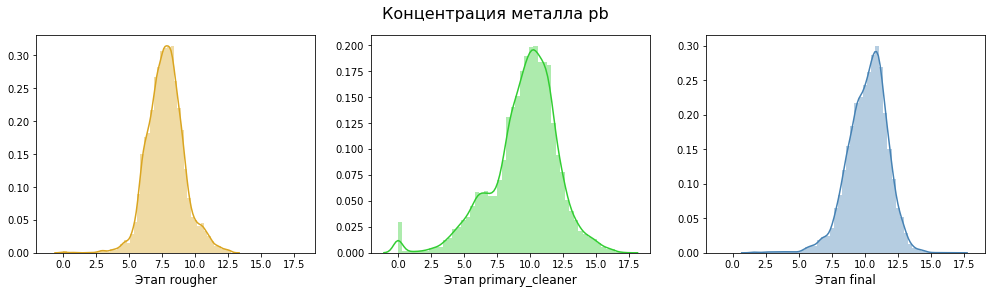

In [21]:
stages = ['rougher', 'primary_cleaner', 'final']
metals = ['au', 'ag', 'pb']
colors = ['goldenrod', 'limegreen', 'steelblue']

for metal in metals:
    i = 0
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 4), sharex=True)

    for stage in stages:
        sns.distplot(gold_recovery_train[stage+'.output.concentrate_'+metal], ax=ax[i], color=colors[i])
        ax[i].set_xlabel('Этап '+stage, fontsize=12)
        i+=1

    fig.suptitle('Концентрация металла '+metal, fontsize=16)
    plt.show()

- Концентрация Au увеличивается более чем в 2 раза на финальном этапе

- Концентрация Ag уменьшается более чем в 2 раза

- Концентрация Pb практически не меняется

- Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

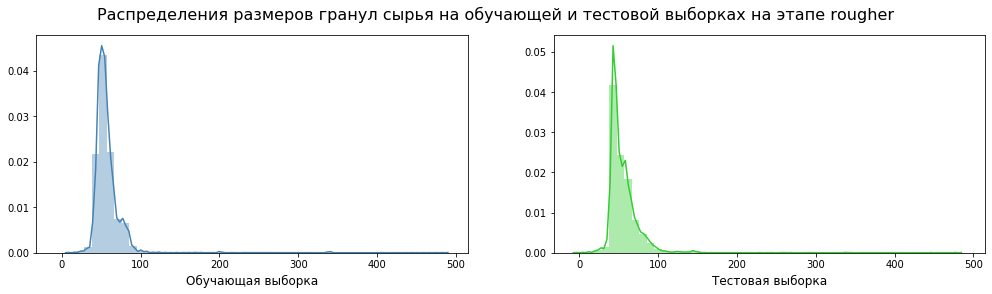

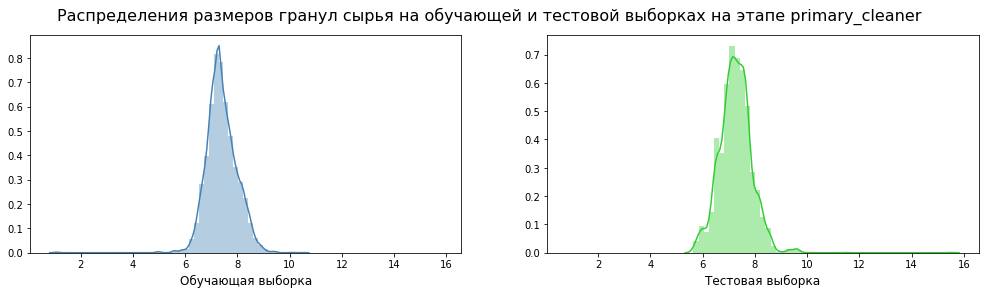

In [22]:
stages = ['rougher', 'primary_cleaner']

for stage in stages:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 4), sharex=True)

    sns.distplot(gold_recovery_train[stage+'.input.feed_size'], ax=ax1, color='steelblue')
    sns.distplot(gold_recovery_test[stage+'.input.feed_size'].dropna(), ax=ax2, color='limegreen')

    ax1.set_xlabel('Обучающая выборка', fontsize=12)
    ax2.set_xlabel('Тестовая выборка', fontsize=12)

    fig.suptitle('Распределения размеров гранул сырья на обучающей и тестовой выборках на этапе '+stage, fontsize=16)
    plt.show()

- Распределения размеров гранул сырья на обучающей и тестовой выборках сопоставимы

-  Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

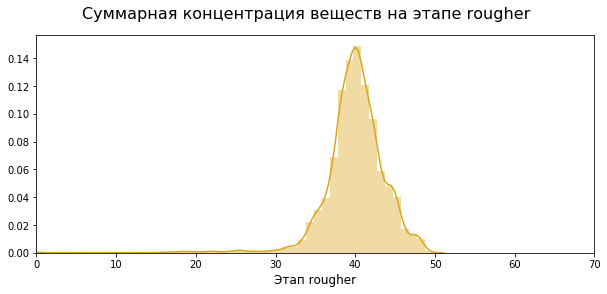

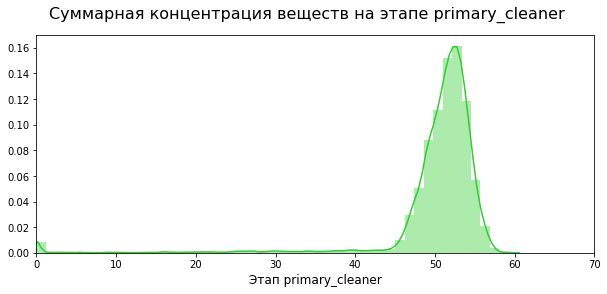

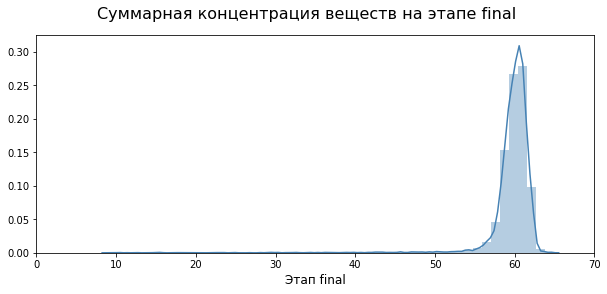

In [23]:
stages = ['rougher', 'primary_cleaner', 'final']
colors = ['goldenrod', 'limegreen', 'steelblue']

i = 0
for stage in stages:
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), sharex=True)
    summ_concentration = gold_recovery_train[stage+'.output.concentrate_au']+gold_recovery_train[stage+'.output.concentrate_ag']+gold_recovery_train[stage+'.output.concentrate_pb']
    
    sns.distplot(summ_concentration, ax=ax, color=colors[i])
    
    ax.set_xlim([0, 70])
    ax.set_xlabel('Этап '+stage, fontsize=12)
    fig.suptitle('Суммарная концентрация веществ на этапе '+stage, fontsize=16)
    plt.show()
    
    i+=1

- Распределения суммарных концентраций выглядят адекватно, за исключением нулевых аномалий, которые следует удалить из обучающей выборки

In [24]:
for stage in stages:

    gold_recovery_train = gold_recovery_train.loc[ gold_recovery_train[stage+'.output.concentrate_au']+
                                                   gold_recovery_train[stage+'.output.concentrate_ag']+
                                                   gold_recovery_train[stage+'.output.concentrate_pb'] >0]

# 3. Модель

- Перед началом исследования зададим значение генератора псевдослучаных значений

In [25]:
random_state = 12345

- Напишим функцию для вычисления итоговой sMAPE

In [26]:
def sMAPE(true, predict):
    error = 1/(len(true))*sum(abs(true - predict)/((abs(true) + abs(predict))/2)) * 100
    return error

- Обучим модель для этапа флотации


- Подготовим обучающую выборку


- Оставим только те столбцы, которые относятся к этапу флотации в тестовой выборке и целевой признак обогащения

In [27]:
rougher_columns = []
for column in gold_recovery_test.columns:
    if 'rougher' in column:
        rougher_columns.append(column)

train_rougher = gold_recovery_train[rougher_columns+['rougher.output.recovery']]

train_rougher.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10737 entries, 0 to 16859
Data columns (total 23 columns):
rougher.input.feed_ag                 10737 non-null float64
rougher.input.feed_pb                 10737 non-null float64
rougher.input.feed_rate               10737 non-null float64
rougher.input.feed_size               10737 non-null float64
rougher.input.feed_sol                10737 non-null float64
rougher.input.feed_au                 10737 non-null float64
rougher.input.floatbank10_sulfate     10737 non-null float64
rougher.input.floatbank10_xanthate    10737 non-null float64
rougher.input.floatbank11_sulfate     10737 non-null float64
rougher.input.floatbank11_xanthate    10737 non-null float64
rougher.state.floatbank10_a_air       10737 non-null float64
rougher.state.floatbank10_a_level     10737 non-null float64
rougher.state.floatbank10_b_air       10737 non-null float64
rougher.state.floatbank10_b_level     10737 non-null float64
rougher.state.floatbank10_c_air      

- Разделим признаки на обучающей выборке

In [28]:
train_features_rougher = train_rougher.drop(['rougher.output.recovery'], axis=1)
train_target_rougher = train_rougher['rougher.output.recovery']

In [29]:
train_features_rougher.shape

(10737, 22)

- Проведем масштабирование признаков

In [30]:
scaler_rougher = MinMaxScaler(feature_range=(0, 1))

scaler_rougher.fit(train_features_rougher) 

train_features_rougher = scaler_rougher.transform(train_features_rougher)

- Зададим стратегию кросс-валидации

In [31]:
cv = ShuffleSplit(n_splits=5, test_size=.25, random_state=random_state)

- Зададим модель

In [32]:
model_rougher = SGDRegressor(random_state=random_state)

- Зададим параметры для подбора

In [33]:
parameters_grid = {
    'penalty' : ['l2', 'l1', 'elasticnet'],
    'max_iter' : range(1000, 3000, 500),
    'loss' : ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
}

- Чтобы сократить время поиска оптимальных параметров по заданному гриду, воспользуемся подходом randomized search, позволяющим отбросить значения параметров при которых достигается заведомо низкая точность модели

In [34]:
score_sMAPE = make_scorer(score_func=sMAPE, greater_is_better=False)

model_rougher_grid_cv = RandomizedSearchCV(model_rougher, parameters_grid, n_iter=10, scoring=score_sMAPE, cv=cv)

In [35]:
%%time
model_rougher_grid_cv.fit(train_features_rougher, train_target_rougher)

CPU times: user 25 s, sys: 4.06 s, total: 29.1 s
Wall time: 29.6 s


RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.25, train_size=None),
                   error_score='raise-deprecating',
                   estimator=SGDRegressor(alpha=0.0001, average=False,
                                          early_stopping=False, epsilon=0.1,
                                          eta0=0.01, fit_intercept=True,
                                          l1_ratio=0.15,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=1000,
                                          n_iter_no_change=5, penalty='l2',
                                          po...
                                          warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'loss': ['squared_loss', 'huber',
                                                 'epsilon_insensitive',
                                   

In [36]:
print('sMAPE наилучшей модели на кросс-валидационной выборке:', abs(model_rougher_grid_cv.best_score_))
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке:')
print()
print(model_rougher_grid_cv.best_params_)

sMAPE наилучшей модели на кросс-валидационной выборке: 4.74156263755115

Параметры для наилучшей модели на кросс-валидационной выборке:

{'penalty': 'l1', 'max_iter': 1500, 'loss': 'squared_epsilon_insensitive'}


- Резульатат sMAPE для модели флотации удовлетворительный


- Стоит учитывать, что RandomizedSearchCV возвращает значение метрики с обратным знаком

In [37]:
model_rougher = SGDRegressor(penalty='l1', max_iter=2500, loss='squared_epsilon_insensitive', random_state=random_state)

model_rougher.fit(train_features_rougher, train_target_rougher)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_epsilon_insensitive',
             max_iter=2500, n_iter_no_change=5, penalty='l1', power_t=0.25,
             random_state=12345, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

- Аналогично получим модель для финального этапа, но уже со всеми признаками

In [38]:
final_columns = []
for column in gold_recovery_train.columns:
    if column in gold_recovery_test.columns:
        final_columns.append(column)

        
train_final = gold_recovery_train[final_columns+['final.output.recovery']].drop(['date'], axis=1)

train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10737 entries, 0 to 16859
Data columns (total 53 columns):
primary_cleaner.input.sulfate                 10737 non-null float64
primary_cleaner.input.depressant              10737 non-null float64
primary_cleaner.input.feed_size               10737 non-null float64
primary_cleaner.input.xanthate                10737 non-null float64
primary_cleaner.state.floatbank8_a_air        10737 non-null float64
primary_cleaner.state.floatbank8_a_level      10737 non-null float64
primary_cleaner.state.floatbank8_b_air        10737 non-null float64
primary_cleaner.state.floatbank8_b_level      10737 non-null float64
primary_cleaner.state.floatbank8_c_air        10737 non-null float64
primary_cleaner.state.floatbank8_c_level      10737 non-null float64
primary_cleaner.state.floatbank8_d_air        10737 non-null float64
primary_cleaner.state.floatbank8_d_level      10737 non-null float64
rougher.input.feed_ag                         10737 non-null fl

- Разделим признаки на обучающей выборке

In [39]:
train_features_final = train_final.drop(['final.output.recovery'], axis=1)
train_target_final = train_final['final.output.recovery']

- Проведем масштабирование признаков

In [40]:
scaler_final = MinMaxScaler(feature_range=(0, 1))

scaler_final.fit(train_features_final) 

train_features_final = scaler_final.transform(train_features_final)

- Зададим модель

In [41]:
model_final = SGDRegressor(random_state=random_state)

- Чтобы сократить время поиска оптимальных параметров по заданному гриду, воспользуемся подходом randomized search, позволяющим отбросить значения параметров при которых достигается заведомо низкая точность модели

In [42]:
model_final_grid_cv = RandomizedSearchCV(model_final, parameters_grid, n_iter=10, scoring=score_sMAPE, cv=cv)

In [43]:
%%time
model_final_grid_cv.fit(train_features_final, train_target_final)

CPU times: user 27 s, sys: 4.31 s, total: 31.3 s
Wall time: 31.6 s


RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=12345, test_size=0.25, train_size=None),
                   error_score='raise-deprecating',
                   estimator=SGDRegressor(alpha=0.0001, average=False,
                                          early_stopping=False, epsilon=0.1,
                                          eta0=0.01, fit_intercept=True,
                                          l1_ratio=0.15,
                                          learning_rate='invscaling',
                                          loss='squared_loss', max_iter=1000,
                                          n_iter_no_change=5, penalty='l2',
                                          po...
                                          warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'loss': ['squared_loss', 'huber',
                                                 'epsilon_insensitive',
                                   

In [44]:
print('sMAPE наилучшей модели на кросс-валидационной выборке:', abs(model_final_grid_cv.best_score_))
print()
print('Параметры для наилучшей модели на кросс-валидационной выборке:')
print()
print(model_final_grid_cv.best_params_)

sMAPE наилучшей модели на кросс-валидационной выборке: 7.060859937323921

Параметры для наилучшей модели на кросс-валидационной выборке:

{'penalty': 'l1', 'max_iter': 2500, 'loss': 'squared_loss'}


- Резульатат sMAPE для модели финального этапа удовлетворительный

In [45]:
model_final = SGDRegressor(penalty='l1', max_iter=2000, loss='squared_epsilon_insensitive', random_state=random_state)

model_final.fit(train_features_final, train_target_final)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_epsilon_insensitive',
             max_iter=2000, n_iter_no_change=5, penalty='l1', power_t=0.25,
             random_state=12345, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

## Проверим решение на тестовой выборке


- В тестовой выборке представлены признаки для предсказания, а настоящие результаты возьмем из исходной выборки

In [46]:
gold_recovery_test[['rougher.output.recovery', 'final.output.recovery']] = gold_recovery_full.set_index('date')[['rougher.output.recovery', 'final.output.recovery']].loc[gold_recovery_test.set_index('date').index].reset_index().drop('date', axis=1)
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 55 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

- Удалим пропуски из тестовой выборки

In [47]:
gold_recovery_test.dropna(inplace=True)

- Подготовим признаки для этапа флотации

In [48]:
test_rougher = gold_recovery_test[rougher_columns+['rougher.output.recovery']]

test_features_rougher = test_rougher.drop(['rougher.output.recovery'], axis=1)
test_target_rougher = test_rougher['rougher.output.recovery']

test_features_rougher = scaler_rougher.transform(test_features_rougher)

- Рассчитаем sMAPE для этапа флотации

In [49]:
predict_rougher = model_rougher.predict(test_features_rougher)
sMAPE_rougher = sMAPE(test_target_rougher, predict_rougher)
print('sMAPE этапа флотации: ', sMAPE_rougher)

sMAPE этапа флотации:  7.84367074067682


- Подготовим признаки для финального этапа

In [50]:
test_final = gold_recovery_test[final_columns+['final.output.recovery']].drop(['date'], axis=1)

test_features_final = test_final.drop(['final.output.recovery'], axis=1)
test_target_final = test_final['final.output.recovery']

test_features_final = scaler_final.transform(test_features_final)

- Рассчитаем sMAPE для финального этапа

In [51]:
predict_final = model_final.predict(test_features_final)

sMAPE_final = sMAPE(test_target_final, predict_final)

print('sMAPE финального этапа: ', sMAPE_final)

sMAPE финального этапа:  8.726821342537448


- Рассчитаем итоговый sMAPE

In [52]:
sMAPE_result = 0.25*sMAPE_rougher + 0.75*sMAPE_final

print('Итоговый sMAPE составляет: ',sMAPE_result)

Итоговый sMAPE составляет:  8.506033692072291


## Сравним результаты обучения с константной моделью

- Рассчитаем sMAPE константной модели этапа флотации

In [53]:
dummy_model_rougher = DummyRegressor(strategy='median')
    
dummy_model_rougher.fit(train_features_rougher, train_target_rougher)

dummy_predict_rougher = dummy_model_rougher.predict(test_features_rougher)

sMAPE_dummy_rougher = sMAPE(test_target_rougher, dummy_predict_rougher)

print('sMAPE константной модели этапа флотации: ', sMAPE_dummy_rougher)

sMAPE константной модели этапа флотации:  8.612817646733935


- Рассчитаем sMAPE константной модели финального этапа

In [54]:
dummy_model_final = DummyRegressor(strategy='median')
    
dummy_model_final.fit(train_features_final, train_target_final)

dummy_predict_final = dummy_model_final.predict(test_features_final)

sMAPE_dummy_final = sMAPE(test_target_final, dummy_predict_final)

print('sMAPE константной модели финального этапа: ', sMAPE_dummy_final)

sMAPE константной модели финального этапа:  9.25569088156039


- Рассчитаем итоговый sMAPE константной модели

In [55]:
sMAPE_dummy_result = 0.25*sMAPE_dummy_rougher + 0.75*sMAPE_dummy_final

print('Итоговый sMAPE константной модели составляет: ',sMAPE_dummy_result)

Итоговый sMAPE константной модели составляет:  9.094972572853777


- Сравним итоговые значения sMAPE

In [56]:
data = {'Модель':['SGDRegressor', 'Константная'],
        'sMAPE этапа флотации' : [sMAPE_rougher, sMAPE_dummy_rougher],
        'sMAPE финального этапа' : [sMAPE_final, sMAPE_dummy_final],
        'sMAPE итоговый' : [sMAPE_result, sMAPE_dummy_result]
       }

results = pd.DataFrame(data)

display(results.sort_values(by='sMAPE итоговый', ascending=True).round(1).set_index('Модель'))

,sMAPE этапа флотации,sMAPE финального этапа,sMAPE итоговый
Модель,,,
SGDRegressor,7.8,8.7,8.5
Константная,8.6,9.3,9.1


- Полученная модель SGDRegressor показала более хорошие резульаты метрики sMAPE по сравнению с константной моделью на всех этапах процесс, что говорит об адекватности ее использования

- В итоге можно сделать вывод, что значение метрики sMAPE для финального этапа оказалось значительно выше, чем для этапа флотации 